In [1]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import combinations, product
from tqdm import tqdm  # progress bar
from math import sqrt

In [2]:
# import data
allTrain = pd.read_csv('D:/notebooks/coursework/dataset/train.csv')
n = len(allTrain)
X_train = allTrain.drop('label', 1).to_numpy()
Y_train = allTrain['label'].to_numpy()
del allTrain
test = pd.read_csv('D:/notebooks/coursework/dataset/test.csv')
X_test = test.to_numpy()
print("data import complete")

C:\Users\ALEX\AppData\Local\Temp\ipykernel_10660\1560496564.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = allTrain.drop('label', 1).to_numpy()


data import complete


In [3]:
class Hamming_Net(object):
    def __init__(self, x):
        self.k = len(x)
        self.m = len(x[0])
        self.w = np.zeros((self.k, self.m))
        for i in range(self.k):
            for j in range(self.m):
                self.w[i][j] = (x[i][j]) / 2
        self.T = self.m / 2  # параметр активационной функции
        self.e = round(1 / len(x), 1)
        self.E = [[0 for j in range(self.k)] for i in range(self.k)]
        self.Emax = 0.000001  # максимально допустимое значение нормы разности выходных векторов на двух последовательных итерациях
        self.U = 1 / self.Emax
        for i in range(self.k):
            for j in range(self.k):
                if j == i:
                    self.E[i][j] = 1.0
                else:
                    self.E[i][j] = -self.e

    def defineLabel(self, y):
        s = [self.product(self.w, y, self.T)]
        p = self.action(s[0], self.U, self.Emax)
        y = [p]
        i = 0
        p = [0 for j in range(len(s[0]))]
        while self.norm(y[i], p) >= self.Emax:
            s.append([0 for j in range(len(s[0]))])
            for j in range(len(s[0])):
                s[i + 1][j] = y[i][j] - self.e * self.mysum(y[i], j)
            y.append((self.action(s[i + 1], self.U, self.Emax)))
            i += 1
            p = y[i - 1]
        # print("label is {}".format(y[len(y) - 1].index(max(y[len(y) - 1])) + 1))
        return y[len(y) - 1].index(max(y[len(y) - 1])) + 1

    def processBatch(self, Y):
        '''input should be same size format as patterns. Implements asynchronous update'''
        return np.array([self.defineLabel(y) for y in tqdm(Y)])

    def change(self, v, a, b):  # функция для преобразования вектора v в матрицу заданных размеров a и b
        t = [[0 for j in range(a)] for i in range(b)]
        k = 0
        j = 0
        while k < b:
            i = 0
            while i < a:
                t[k][i] = v[j]
                j += 1
                i += 1
            k += 1
        return t

    def product(self, w, y, T):  # функция умножения матрицы на вектор
        z = []
        for i in range(len(w)):
            x = 0
            for j in range(len(y)):
                x = x + w[i][j] * y[j]
            z.append((x + T))
        return z

    def action(self, s, T, Emax):  # активационная функция
        t = []
        for i in s:
            if i <= 0:
                t.append(0)
            elif 0 < i <= T:
                t.append(Emax * i)
            elif i > T:
                t.append(T)
        return t

    def mysum(self, y, j):  # функция для вычисления суммы значений вектора при  i != j
        p = 0
        sum = 0
        while p < len(y):
            if p != j:
                sum = sum + y[p]
            p += 1
        return sum

    def norm(self, v, p):  # функция вычисляющая разность двух векторов и вычисляющая норму получившегося вектора
        t = []
        for i in range(len(v)):
            t.append(v[i] - p[i])
        sum = 0
        for i in t:
            sum += i * i
        return sqrt(sum)

100%|██████████| 8/8 [00:00<?, ?it/s]


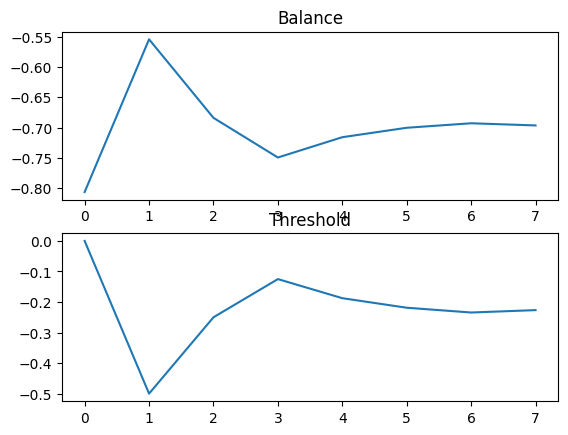

In [4]:
# create patterns
supervised = True
factor = 2.0 / np.max(X_train)
avg_classes = lambda: np.array([factor * np.mean(X_train[Y_train == l, :], axis=0) - 1.0
                                for l in np.unique(Y_train)])
patterns = avg_classes() if supervised else (factor * X_train - 1)

# convert to bitwise
low = -1.0
high = 1.0
iters = 8
metric = np.zeros(iters)
threshold = np.zeros(iters)
for i in tqdm(range(iters)):
    threshold[i] = (low + high) / 2
    metric[i] = np.mean(np.where(patterns < threshold[i], -1, 1))
    if metric[i] > -0.7:  # 0.7 chosen by inspection
        low = threshold[i]
    else:
        high = threshold[i]
bitPatterns = np.where(patterns < threshold[-1], -1, 1)
XB_train = np.where((factor * X_train - 1) < threshold[-1], -1, 1) if supervised else bitPatterns
XB_test = np.where((factor * X_test - 1) < threshold[-1], -1, 1)

plt.subplot(211)
plt.title('Balance')
plt.plot(metric)
plt.subplot(212)
plt.title('Threshold')
plt.plot(threshold)

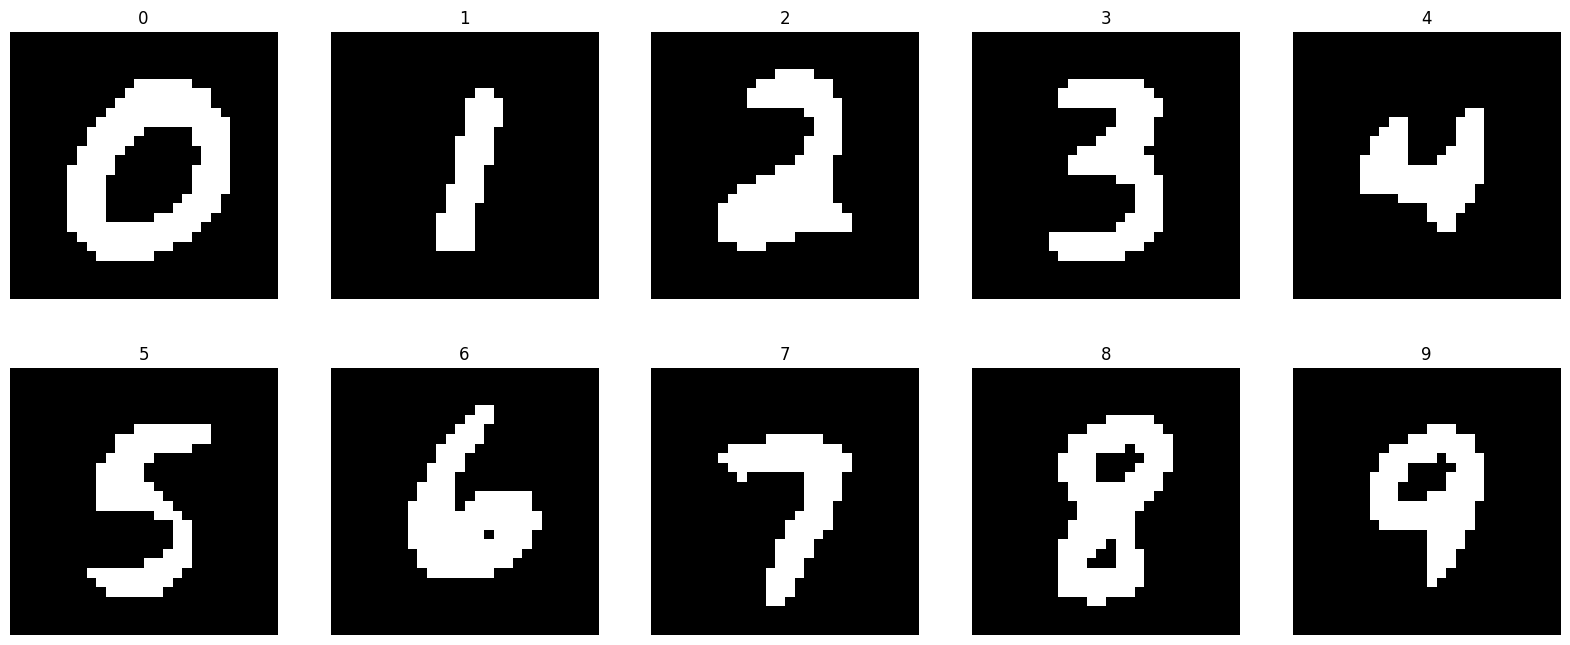

In [5]:
#peek at patterns
plt.figure(figsize=[20, 8])
for i in range(min(len(bitPatterns), 10)):
    plt.subplot(2, 5, i + 1)
    plt.title(i if supervised else Y_train[i])
    plt.axis('off')
    plt.imshow(bitPatterns[i].reshape((28, 28)), cmap='gray')

In [ ]:
hamming = Hamming_Net(bitPatterns)
predict = hamming.processBatch(XB_train)

 11%|█         | 4651/42000 [00:23<03:05, 201.35it/s]

In [ ]:
predict = hamming.processBatch(XB_train)

In [ ]:
plt.figure(figsize=[20, 8])
for i, c in enumerate(np.random.choice(len(XH_train), 5, False)):
    l = Y_train[c]

    # original image
    plt.subplot(2, 5, i + 1)
    plt.title("{} Original".format(l))
    plt.axis('off')
    plt.imshow(X_train[c].reshape((28, 28)), cmap='gray')

    # processed image
    plt.subplot(2, 5, i + 6)
    plt.title("{} Processed".format(l))
    plt.axis('off')
    plt.imshow(XH_train[c].reshape((28, 28)), cmap='gray')

In [ ]:
from scipy.spatial import distance


def determineLabel(x):
    leastDistance = 100
    label = 0
    for lbl, b in enumerate(bitPatterns):
        dst = distance.euclidean(x, b)
        if (dst < leastDistance):
            leastDistance = dst
            label = lbl
    return label


def getLabelByLeastRange(X):
    return np.array([determineLabel(x) for x in X])


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_train, getLabelByLeastRange(XH_train)))